# MultipleObjectTracker

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=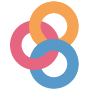)](https://)

---

This is a work in progress tutorial, more to come soon!

In [1]:
%load_ext autoreload
%autoreload 2

## Overview

This notebook is a walkthrough of the tracking components of the soccertrack library. We will cover the following topics:

* The `Tracklet` Class
* The `MotionModel` Class
* The `SingleObjectTracker` Class
* The `MultiObjectTracker` Class

##  The `Tracklet` Class

This tutorial will guide you through using the `Tracklet` class.

### What is a Tracklet?

A `Tracklet` is a class that can be used to keep track of a single object in a video sequence. The class itself does not have any tracking capabilities, but can be used in conjunction with `SingleObjectTracker` or `MultiObjectTracker` classes to track single or multiple objects in a video sequence.

### Toy Problem

Lets simulate a simple toy problem to demonstrate how to use the `Tracklet` class. We will simulate a single object moving in a straight line with a constant velocity. We will also add some noise to the position measurements to simulate a real world scenario.

I've added a `score` attribute to the detections. This score negatively correlates to the amount of noise added to the position measurements so we can filter out detections with a low score later on.

In [2]:
from sportslabkit.notebook_utils import simulate_moving_object, display_tracking_animation

num_frames = 50
detections, ground_truth_positions = simulate_moving_object(num_frames)
display_tracking_animation(detections, ground_truth_positions)

print("detections@t=0:", detections[0])
print("ground_truth_positions@t=0:", ground_truth_positions[0])

detections@t=0: Detection(box=[-12  91  25  25], score=0.90537, class_id=1, feature=None)
ground_truth_positions@t=0: [3, 113, 25, 25]


### Using the Tracklet class

Let me briefly explain the main attributes of the `Tracklet` class.

#### Attributes

* `id`: A unique identifier for the tracklet.
* `steps_alive`: The number of frames since the tracklet was created.
* `staleness`: The number of frames since the last detection was added to the tracklet.
* `max_staleness`: The maximum number of frames a tracklet can go without a detection before it is considered stale.
* `_observations`: A dictionary of detections that have been added to the tracklet.

by using the `print()` method we can pretty print the attributes mentioned above.

In [3]:
from sportslabkit import Tracklet

tracklet = Tracklet()
tracklet.register_observation_types(["box", "score"])
tracklet.print()

╔════════════════════════════════════════════════════════════════════════════╗
║ Tracklet(id=314626904153, steps_alive=0, staleness=0.0, is_active=False)   ║
╟────────────────────────────────────────────────────────────────────────────╢
║  box: []                                                                   ║
║  score: []                                                                 ║
╚════════════════════════════════════════════════════════════════════════════╝


Obeservations are a special type of attribute that can be accessed using the `get_observation()` and `get_observations()` methods or by dot notation.

Let's look at the other methods of the `Tracklet` class as well

#### Methods

* `register_observation_type(name: str)`: 
  * Registers a new observation type with the specified name. This allows the tracklet to store and manage observations of this type.
* `update_observation(name: str, value: Any)`: 
  * Updates the specified observation type with a new value. The value is appended to the list of observations for that type.
* `update_current_observation(name: str, value: Any)`: 
  * Updates the most recent value of the specified observation type with a new value.
* `get_observation(name: Optional[str] = None)`: 
  * Returns the most recent value of the specified observation type. If the name is not provided, it returns the most recent value for all observation types.
* `get_observations(name: Optional[str] = None)`: 
  * Returns a list of all values for the specified observation type. If the name is not provided, it returns a dictionary containing all observation types and their respective values.
* `update(detection: Union[Detection, None], global_step: Optional[int] = None, **kwargs)`:
  * Updates the tracklet with a new detection and optional additional observation values. The tracklet's state will be updated based on the provided detection and global step.
* `is_active()`: 
  * Checks if the tracklet is active.
* `is_stale()`: 
  * Checks if the tracklet is stale. 
* `is_invalid()`: 
  * Checks if the tracklet has None values in its most recent observations.
* `to_bbdf()`: 
  * Converts the tracklet's predictions into a BBoxDataFrame.
* `print(num_recent_obs: int = 1, use_colors: bool = False)`: 
  * Pretty prints the tracklet's attributes.

Below, we'll see how to update a tracklet with a new detection and how to access the observations.

In [4]:
def convert_det_to_obs(detection):
    return {
        'box': detection.box,
        'score': detection.score,
    }
    
det0 = detections[0]
print("det0:", det0.box)

print("tracklet before update:", tracklet.box)
obs = convert_det_to_obs(det0)
tracklet.update_observations(obs)
print("tracklet after update:", tracklet.box)

det0: [-12  91  25  25]
tracklet before update: None
tracklet after update: [-12  91  25  25]


In [5]:
# add all the remaining detections
for det in detections[1:]:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)

print(f"Most recent observation: {tracklet.box}") # or tracklet.get_observation('box')
print(f"3 most recent observations: {tracklet.get_observations('box')[-3:]}")

# We can also print extended information about the tracklet
tracklet.print(num_recent_obs=3, use_colors=True) # print info for the first 5 frames

Most recent observation: [740 122  25  25]
3 most recent observations: [array([703, 108,  25,  25]), array([726, 133,  25,  25]), array([740, 122,  25,  25])]
╔════════════════════════════════════════════════════════════════════════════╗
║ Tracklet(id=314626904153, steps_alive=0, staleness=0.0, is_active=False)   ║
╟────────────────────────────────────────────────────────────────────────────╢
║  box: [[703 108  25  25], [726 133  25  25], [740 122  25  25]]            ║
║  score: [0.9788126310238942, 0.9817007486706975, 0.9893490475470428]       ║
╚════════════════════════════════════════════════════════════════════════════╝


#### Registering a new observation type

Use the `register_observation_type()` method to register a new observation type. This allows the tracklet to store and manage observations of this type. Below we register a new observation type called 'velocity'. Notice that the observation type is now included in the `print()` method.

In [6]:
tracklet = Tracklet()
tracklet.register_observation_type('velocity')
tracklet.print()

╔════════════════════════════════════════════════════════════════════════════╗
║ Tracklet(id=172408013380, steps_alive=0, staleness=0.0, is_active=False)   ║
╟────────────────────────────────────────────────────────────────────────────╢
║  velocity: []                                                              ║
╚════════════════════════════════════════════════════════════════════════════╝


## The `MotionModel` Class

### Use a Motion Model to predict the next position of the box

On its own the Tracklet is not very useful as it is only able to store observations. In this tutorial we will use it with a `MotionModel` class to filter noisy detections and more accurately estimate the object's position.

All `MotionModel` have a `__call__()` method that takes a `Tracklet` and returns a new predicted state (usually the location).

To learn more and develop your own `MotionModel` class, see the [MotionModel Tutorial]().

#### Using an Exponential Moving Average (EMA) motion model

We can use the ExponentialMovingAverage to predict the next position of the box. The prediction is based on all the observations of the box so far.

In [9]:
from sportslabkit.motion_model.models import ExponentialMovingAverage

tracklet = Tracklet()
tracklet.register_observation_types(['box', 'score'])

for det in detections:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)

ema = ExponentialMovingAverage({'gamma':.1})

# predict the next position
prediction = ema(tracklet)
print(prediction)

[     738.35      122.85          25          25]


## Using the EMA as a filter

The `ExponentialMovingAverage` has one parameter, `gamma`, which controls how much weight is given to the most recent observation. A higher gamma means more weight is given to the most recent observation, and a lower gamma means more weight is given to the older observations. In the example, below you can try changing the gamma value to see how it affects the predicted position.

Lets iterate through the detections and pass them through the ema to get the predicted position of the box.

### Example with low `gamma` value

A low gamma value will make the tracklet more responsive to changes in the observations

In [10]:
gamma=0.2
ema = ExponentialMovingAverage({'gamma':gamma})

predictions = []

tracklet = Tracklet()
tracklet.register_observation_types(['box', 'score'])

for det in detections:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)
    
    prediction = ema(tracklet)
    predictions.append(prediction)

display_tracking_animation(detections, ground_truth_positions, predictions=predictions)

### Example with high `gamma` value

A high gamma value means that the model will be more influenced by the past observations.

In [12]:
gamma=0.8 # try working with different gamma to see how it affects the prediction
ema = ExponentialMovingAverage({'gamma':gamma})

predictions = []

tracklet = Tracklet()
tracklet.register_observation_types(['box', 'score'])

for det in detections:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)
    
    prediction = ema(tracklet)
    predictions.append(prediction)

display_tracking_animation(detections, ground_truth_positions, predictions=predictions)

## Other Motion Models

#### Using a Kalman Filter motion model

Next we can use the KalmanFilter to predict the next position of the box.

The `KalmanFilterMotionModel` has three parameters, dt, process_noise and measurement_noise. 

* `dt` is the time step between observations. In this example, the time between frames is 1, so we set dt to 1.
* `process_noise` is the amount of noise to add to the predicted position. In this example, the position measurements are noisy so we set this to 10.
* `measurement_noise` is the amount of noise to add to the position measurements. In this example, the position measurements are noisy so we set this to 10.

Before iterating through the detections, we need to decide on what to set the parameters. In this example, the position measurements are noisy so we set the process_noise and measurement_noise to 10. We also set the dt to 1 as the time between frames is 1.

Lets iterate and also calculate the IoU between the predicted position and the ground truth position.

In [14]:
from sportslabkit.motion_model.models import KalmanFilterMotionModel
from sportslabkit.metrics.object_detection import iou_scores

dt = 1  # time step between observations
process_noise = 10  # process noise
measurement_noise = 100  # measurement noise

kf_model = KalmanFilterMotionModel({'dt':dt, 'process_noise':process_noise, 'measurement_noise':measurement_noise})
predictions = []

tracklet = Tracklet()
tracklet.register_observation_types(['box', 'score'])

for det in detections:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)

    prediction = kf_model(tracklet)
    predictions.append(prediction)

score = iou_scores(ground_truth_positions, predictions, xywh=True)
print(f"Average IoU score: {score:.2f}")

display_tracking_animation(detections, ground_truth_positions, predictions=predictions)

Average IoU score: 0.46


#### Tuning the Motion Model

As we can see above, the `KalmanFilterMotionModel` can improve the tracking performance by filtering out noisy detections. However, the performance is still not great. This is because the parameters of the motion model have not been tuned to the problem.

We can use the `tune_motion_model` function to find the optimal parameters for the motion model. The function takes a list of detections and a list of ground truth positions as input, and returns the optimal parameters for the motion model.

Each `MotionModel` has a default `hparam_search_space` class variable which contains a dictionary of hyperparameters and their search space. This can be overridden by passing a dictionary of hyperparameters and their search space to the `tune_motion_model` function.

In [15]:
KalmanFilterMotionModel.hparam_search_space

{'dt': {'type': 'categorical',
  'values': [10,
   2,
   1,
   0.03333333333333333,
   0.016666666666666666,
   0.008333333333333333]},
 'process_noise': {'type': 'logfloat', 'low': 1e-06, 'high': 100.0},
 'measurement_noise': {'type': 'logfloat', 'low': 0.001, 'high': 100.0},
 'confidence_scaler': {'type': 'logfloat', 'low': 0.001, 'high': 100}}

For tuning, we use Optuna to search the hyperparameter space. Optuna is a hyperparameter optimization framework that uses the Tree-structured Parzen Estimator (TPE) algorithm to find the optimal hyperparameters. You can read more about Optuna [here](https://optuna.readthedocs.io/en/stable/).

Be sure that when you define the search space the hyperparameter names match the names of the hyperparameters in the `hparam_search_space` dictionary. They must also contain data type and range information.

Currently, Optuna supports three data types,

* `categorical` - Categorical variables. No range is required. But you must provide the values to choose from as a list.
* `int` - Integer variables. You must provide the lower and upper bounds of the range as a tuple.
* `float` - Floating point variables. You must provide the lower and upper bounds of the range as a tuple.

In [17]:
from sportslabkit.motion_model import tune_motion_model

kf_model = KalmanFilterMotionModel

best_params, best_iou, study = tune_motion_model(kf_model, detections, ground_truth_positions, verbose=False, n_trials=1000, return_study=True)
print("Best parameters:", best_params)
print("Best average IoU:", best_iou)

Best parameters: {'dt': 1, 'process_noise': 1.4181557009163317e-06, 'measurement_noise': 0.010853024957654504, 'confidence_scaler': 0.3001373625265234}
Best average IoU: 0.6209559476309358


In [19]:
kf_model = KalmanFilterMotionModel(best_params)

predictions = []

tracklet = Tracklet()
tracklet.register_observation_types(['box', 'score'])
for det in detections:
    obs = convert_det_to_obs(det)
    tracklet.update_observations(obs)
    
    prediction = kf_model(tracklet)
    predictions.append(prediction)

score = iou_scores(ground_truth_positions, predictions, xywh=True)
print(f"Average IoU score: {score:.2f}")

display_tracking_animation(detections, ground_truth_positions, predictions=predictions)

Average IoU score: 0.62


### Toy Problem

First lets update our toy problem to simulate multiple objects moving in a straight line with a constant velocity. We will also add some noise to the position measurements to simulate a real world scenario. We'll also update the animation function to plot multiple objects.

In [21]:
from sportslabkit.notebook_utils import simulate_moving_objects

detections, ground_truth_positions = simulate_moving_objects(num_objects=3, num_frames=num_frames, frame_drop_rate=0.1)
display_tracking_animation(detections, ground_truth_positions)

Since it is also important to use visual appearance features, we need to generate actual frames.

In [22]:
from sportslabkit.notebook_utils import display_generated_frames, generate_frames

frames = generate_frames(ground_truth_positions)
display_generated_frames(frames)